# Introdution 

The notebook is a behind-the-scenes look at the data wrangling behind the story on *The Urbanizational Evolution of New York City - From Seed to Apple* presented on https://esbenbl.github.io/


The structure of the notebook is:
1. [Motivation](#Motivation)
2. [Basic Statistics](#base_stats)
3. [Data Analysis](#Data Analysis)
4. [Genre](#Genre)

Overall our website and data story structure will be rather linear, structured, with most in common with the magazine visualization genre described by Segel and Heer. But as we also are concerned with keeping the reader active and engaged, we will also incorporate interactive plots in which the reader can explore and engage within the frames of our data story and magazine style, thus if a reader for example have an interest in a specific neighborhood in New York it will be possible to specifically mouse over that and see that neighborhoods data. 

5. [Visualization](#Visualization)
6. [Discussion](#Discussion)
7. [Contribution](#Controbution)
8. [References](#References)

# Motivation <a id="Motivation"></a>


New York is one of the most renowned and global metropolises in the world, some even call it the Capital of the World. In the 19th century due to waves of immigration and industrialization the city's population exploded, also transforming New York. The transformation of New York City’s physical, social and cultural landscape during the 19th time period shaped the cities identity and influenced the development of urban planning, transportation and social policies that continue to shape the city's urban fabric today. Studying the evolution of New York City's urbanization thus provides a rich historical context for understanding contemporary urban challenges and opportunities, making it an interesting and relevant subject for examination. 

We will examine New York's urbanization through data from NYC Department of City Planning, where we will combine two datasets from the department. The first dataset is of the 800.000 buildings in New York and their placement, and the second shows the characteristics of the land use and geographic data which the buildings are built upon. Thus we get a full dataset on both the year of each individual building as well as the type of building, eg. is it commercial or residential. Furthermore we also consider including more data on neighborhood level from New york maybe regarding the overall evolution of other parameters in New York's neighborhoods such as, crime, income, education, or the overall evolution of the metropolis such as subways, schools, hospitals.  etc. 


# Basic Statistics <a id="base_stats"></a>

In [1]:
import geopandas as gpd
import requests 
import matplotlib.pyplot as plt 
plt.rcParams["font.family"] = "Garamond"
import seaborn as sns
import numpy as np
import pandas as pd
import requests
from scipy.interpolate import interp1d

load data

In [2]:
# Building footprints from https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
# Documentation https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_BuildingFootprints.md
building_footprints = gpd.read_file("Exam_datasets/Building_Footprints.geojson") 

# NYC Borough GeoJson
new_york_boroughs_map = gpd.read_file("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/new-york-city-boroughs.geojson")

# PLUTO Data from https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
columns_subset = ["borough","cd", "latitude", "longitude", 'landuse', "assesstot", "numbldgs",
                  "numfloors", "unitstotal", "bldgarea", "comarea", "resarea", "bbl"]
land_use_dataaset = pd.read_csv("Exam_datasets/pluto_22v3_1.csv")[columns_subset]

C:\Users\asger\AppData\Local\Temp\ipykernel_3312\749188831.py:11: DtypeWarning: Columns (21,22,24,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  land_use_dataaset = pd.read_csv("Exam_datasets/pluto_22v3_1.csv")[columns_subset]


## Clean data 

Clean BUILDING FOOTPRINTS

In [3]:
# remove missing construction_years
building_footprints = building_footprints[-pd.isna(building_footprints.cnstrct_yr)].copy() 

# To int 
building_footprints.cnstrct_yr = building_footprints.cnstrct_yr.astype("int64")

# Construct bins 
ten_year_bins = [0]+[year for year in range(1899,2029,10)]+[2030]
ten_year_labels = ["Before 1900"] + [str(year)+"s" for year in range(1900,2020,10)] + ["2020s"]

# Into Bins
building_footprints["cnstrct_yr_intervals"] = pd.cut(building_footprints.cnstrct_yr, bins = ten_year_bins, labels = ten_year_labels)

# Align BBL with PLUTOs datatypes 
building_footprints = building_footprints.rename(columns = {"mpluto_bbl":"bbl"})
building_footprints.bbl = building_footprints.bbl.astype("int64")

# Distinguish geometry  
building_footprints["building_geometry"] = building_footprints.geometry.copy()

clean PLUTO land use data 

In [4]:
# drop nan for PLUTO
land_use_dataaset = land_use_dataaset.dropna().copy() # drop na 
land_use_dataaset.bbl = land_use_dataaset.bbl.astype("int64") # to int 

# Dicts to convert values  
landuse_key = {1:"One & Two Family Building",
                2:"Multi-Family Walk-Up Buildings",
                3:"Multi-Family Elevator Buildings",
                4:"Mixed Residential & Commercial Buildings",
                5:"Commerical & Office Buildings",
                6:"Industrial & Manufacturing Buildings",
                7:"Transportation & Utility",
                8:"Public Facilities & Institutions",
                9:"Open Space & Outdoor Recreation",
                10: "Parking Facilities",
                11:"Vacant Land"}

borough_key = {"BK":"Brooklyn",
               "QN":"Queens",
               "MN":"Manhattan",
               "BX":"Bronx",
               "SI":"Staten Island"}

# Map dicts
land_use_dataaset.borough = land_use_dataaset.borough.apply(lambda x: borough_key[x])
land_use_dataaset["landuse_label"] =  land_use_dataaset.landuse.apply(lambda x: landuse_key[x])

### Merge datasets

In [5]:
buildings_and_landuse = pd.merge(building_footprints, land_use_dataaset, on = "bbl", how = "outer", indicator = True)

### Sanity Check on Merge 

In [6]:
only_in_building_footprints = buildings_and_landuse.query("_merge == 'left_only'")
only_in_pluto = buildings_and_landuse.query("_merge == 'right_only'")

Buildings not found in Building Footprint: 6033


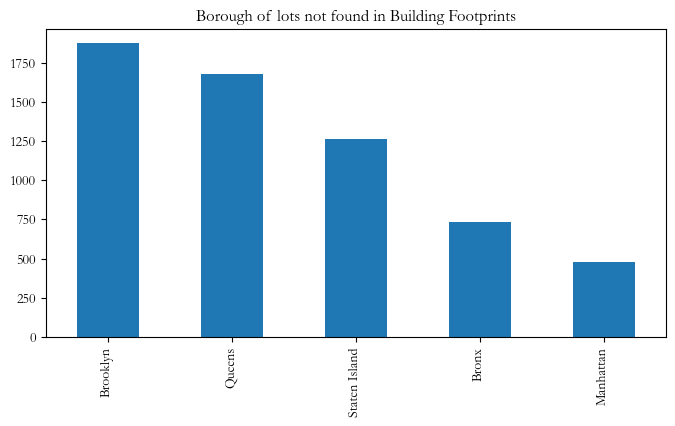

In [7]:
print(f"Buildings not found in Building Footprint: {only_in_pluto.shape[0]}")
only_in_pluto.borough.value_counts().plot.bar(title = "Borough of lots not found in Building Footprints", figsize = (8,4));

Buildings not found in PLUTO: 14410


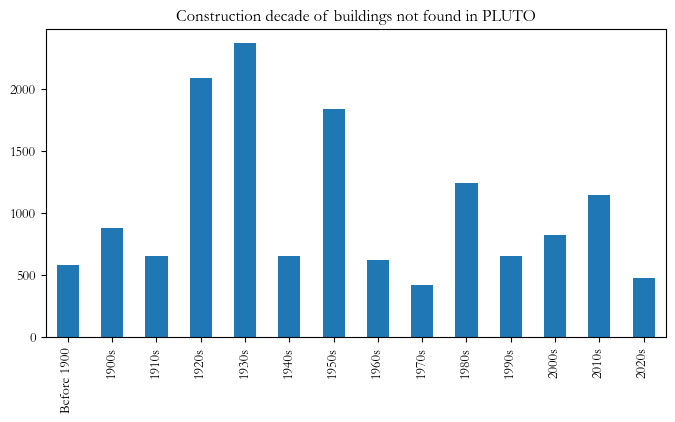

In [8]:
print(f"Buildings not found in PLUTO: {only_in_building_footprints.shape[0]}")
only_in_building_footprints.cnstrct_yr_intervals.value_counts().sort_index().plot.bar(title = "Construction decade of buildings not found in PLUTO", figsize = (8,4));

### Keep only BBL matches

In [9]:
buildings_and_landuse = buildings_and_landuse.query("_merge == 'both'").copy()
buildings_and_landuse.cnstrct_yr = buildings_and_landuse.cnstrct_yr.astype("int64")

# Dimensions of dataset 
buildings_and_landuse.shape

(1069453, 31)

## Plot Data

Plot Construction in different periods

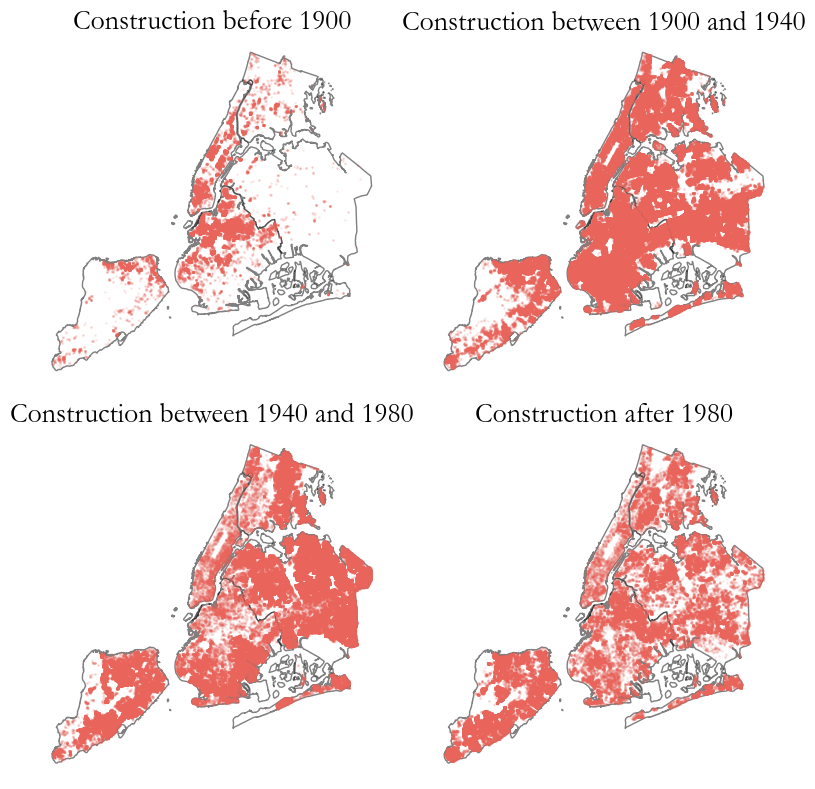

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (8,8))

# Early plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[0][0])
buildings_and_landuse.query("cnstrct_yr < 1900").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[0][0])
ax[0][0].set_title("Construction before 1900", size = 20)
ax[0][0].set_axis_off()

# Middle plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[0][1])
buildings_and_landuse.query("cnstrct_yr >= 1900 & cnstrct_yr < 1940").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[0][1])
ax[0][1].set_title("Construction between 1900 and 1940", size = 20)
ax[0][1].set_axis_off()

# Early plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[1][0])
buildings_and_landuse.query("cnstrct_yr >= 1940 & cnstrct_yr < 1980").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[1][0])
ax[1][0].set_title("Construction between 1940 and 1980", size = 20)
ax[1][0].set_axis_off()

# Middle plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[1][1])
buildings_and_landuse.query("cnstrct_yr >= 1980").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[1][1])
ax[1][1].set_title("Construction after 1980", size = 20)
ax[1][1].set_axis_off()

plt.tight_layout()
plt.show()

Plot Construction by decade 

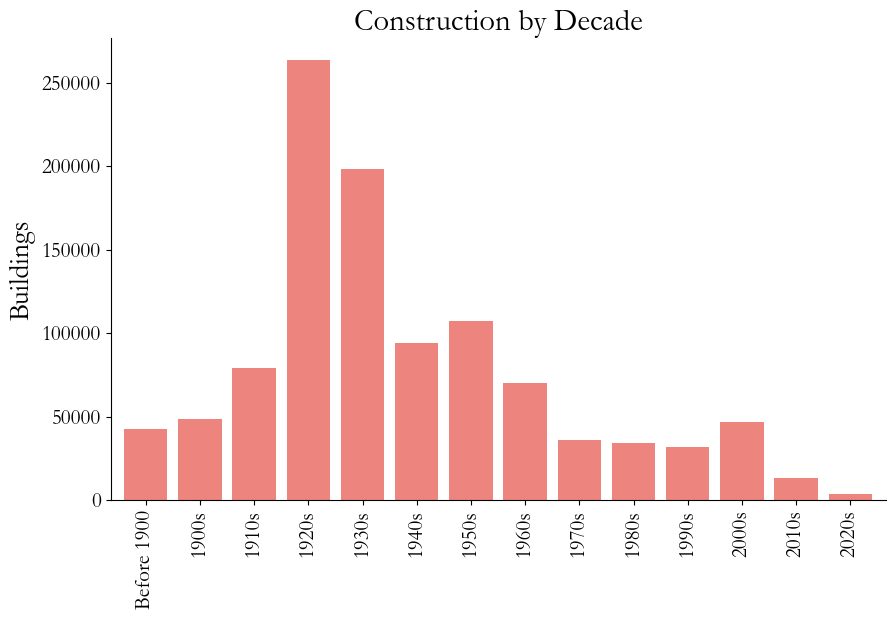

In [12]:
construction_by_year = buildings_and_landuse.groupby("cnstrct_yr_intervals").size().sort_index()

fig, ax  = plt.subplots(figsize = (10,6))
construction_by_year.plot.bar(color = "#E9655C", alpha = 0.8, width = 0.8)
ax.set_title("Construction by Decade", size = 22)
ax.set_ylabel("Buildings", size = 20)
ax.set_xlabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("Plots/construction_by_decade.png", dpi = 300, bbox_inches = "tight")
plt.show()


By land use! 

In [ ]:
''' Make a stacked barplot here, divided into land use '''

### Plots By Bourough 

Removed early observations 

In [13]:
# Removed early observations 
buildings_and_landuse_trimmed = buildings_and_landuse.query("cnstrct_yr >= 1800").copy()

In [14]:
#https://github.com/mwaskom/seaborn/issues/2280
# Ændre position af sns legend 
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legend_handles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text().title()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

Set xtick frequency (and labels, if necesarry)

In [15]:
## OBS - Kan bruges til at ændre xticts, men er ikke nødvendigt ift. position og label (i nedenstående er label og position dog det samme)
custom_xticks_label = []
custom_xticks_position = []

for position, year_label in enumerate(sorted(buildings_and_landuse_trimmed.cnstrct_yr.unique())):
    if year_label%10==0:
        custom_xticks_label.extend([year_label])
        custom_xticks_position.extend([position])

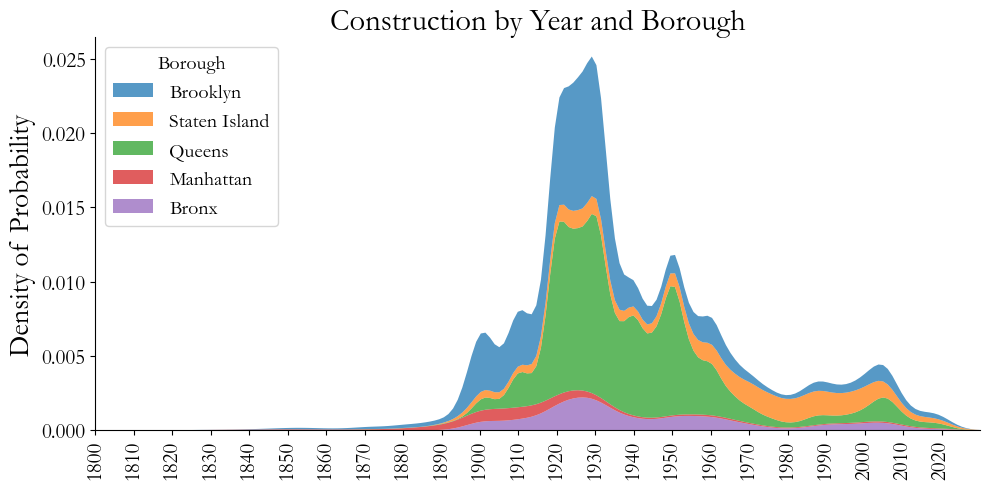

In [16]:
fig, ax  = plt.subplots(figsize = (10,5))
plt.rcParams['legend.title_fontsize'] = 'x-large'

sns.kdeplot(buildings_and_landuse_trimmed, x ="cnstrct_yr", hue = "borough", multiple = "stack", bw_adjust= 1.5, common_norm = True, linewidth = 0, zorder=1, ax = ax)
move_legend(ax, "upper left", fontsize = "x-large")
custom_xticks_position = custom_xticks_label # because x is numerical
ax.set_xticks(ticks = custom_xticks_position, labels=custom_xticks_label, rotation=90)
#ax.axvspan(xmin=1920, xmax=1930, color='#B6B9BB', alpha=0.5, zorder=0)
ax.set_xlim([1800, 2030])
ax.set_title("Construction by Year and Borough", size = 22)

ax.set_ylabel("Density of Probability", size = 20)
ax.set_xlabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("Plots/construction_distribution_by_borough.png", dpi = 300, bbox_inches = "tight")
plt.tight_layout()
plt.show()

In [ ]:
# fig, ax  = plt.subplots(figsize = (10,6))

# sns.kdeplot(buildings_and_landuse_trimmed, x ="cnstrct_yr", hue = "borough", multiple = "stack", bw_adjust= 1.5, common_norm = True, linewidth = 0, cumulative = True,  ax = ax)
# move_legend(ax, "upper left")
# custom_xticks_position = custom_xticks_label # because x is numerical
# ax.set_xticks(ticks = custom_xticks_position, labels=custom_xticks_label, rotation=90)
# ax.set_xlim([1800, 2030])
# ax.set_title("Cumulative Construction by Year and Bourough")

# plt.tight_layout()
# plt.show()

## By Square Feet 

Documentation: 
- COMMERCIAL FLOOR AREA is the sum of floor areas for office, retail, garage,
storage, factory, and other uses.

By land use 

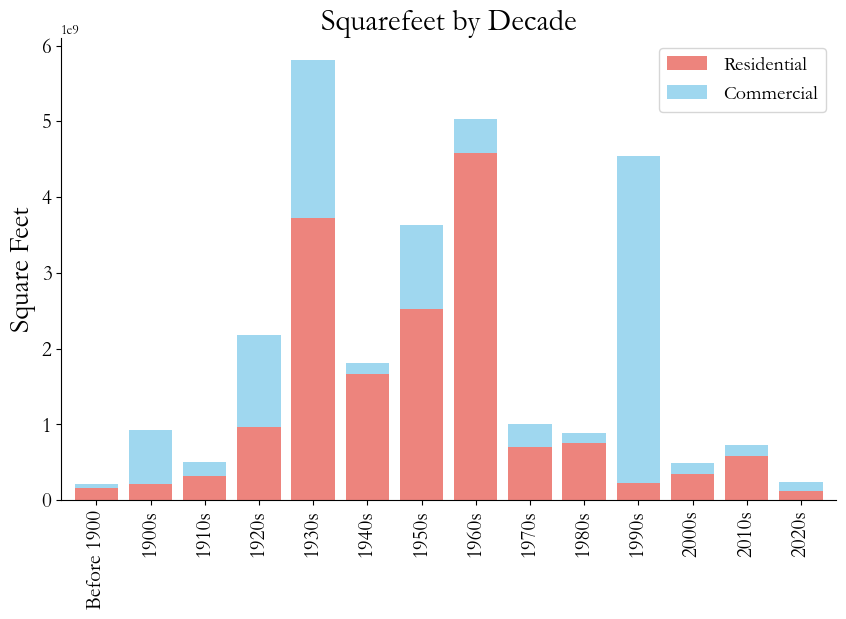

In [18]:
fig, ax  = plt.subplots(figsize = (10,6))


residential_squarefeet_by_decade = buildings_and_landuse.groupby("cnstrct_yr_intervals").resarea.sum().sort_index()
commercial_squarefeet_by_decade = buildings_and_landuse.groupby("cnstrct_yr_intervals").comarea.sum().sort_index()

residential_squarefeet_by_decade.plot.bar(ax=ax, color = "#E9655C",  alpha = 0.8, width = 0.8)
commercial_squarefeet_by_decade.plot.bar(ax=ax, bottom = residential_squarefeet_by_decade, alpha = 0.8, color = "skyblue", width = 0.8)

ax.set_title("Squarefeet by Decade", size = 22)
ax.set_ylabel("Square Feet", size = 20)
ax.set_xlabel("")
ax.legend(["Residential", "Commercial"], fontsize = "x-large")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

OBS - IKKE SIKKER PÅ NEDENSTÅENDE! 

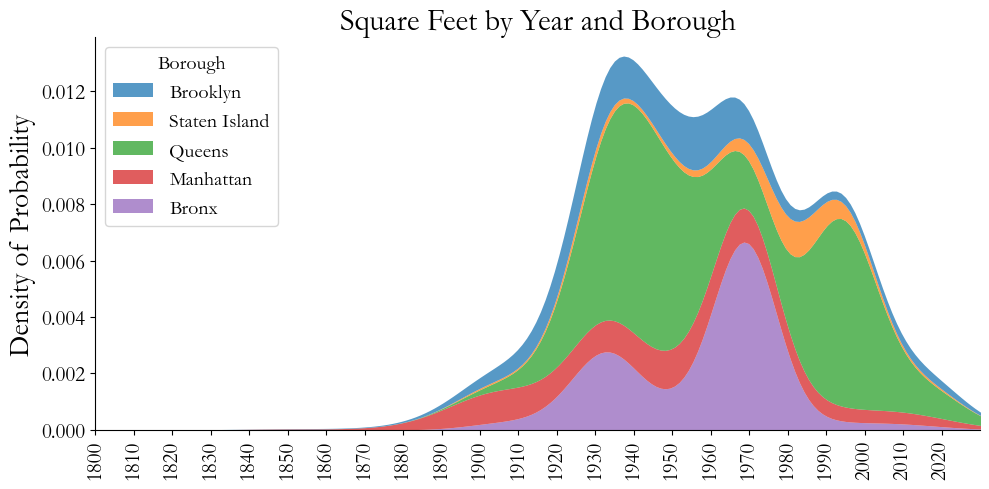

In [19]:
fig, ax  = plt.subplots(figsize = (10,5))
plt.rcParams['legend.title_fontsize'] = 'x-large'

sns.kdeplot(buildings_and_landuse_trimmed, x ="cnstrct_yr",
            hue = "borough",
            weights = "bldgarea", 
            multiple = "stack", 
            bw_adjust= 1.5, 
            common_norm = True, 
            linewidth = 0, 
            zorder=1, 
            ax = ax)

move_legend(ax, "upper left", fontsize = "x-large")
custom_xticks_position = custom_xticks_label # because x is numerical
ax.set_xticks(ticks = custom_xticks_position, labels=custom_xticks_label, rotation=90)
#ax.axvspan(xmin=1920, xmax=1930, color='#B6B9BB', alpha=0.5, zorder=0)
ax.set_xlim([1800, 2030])
ax.set_title("Square Feet by Year and Borough", size = 22)

ax.set_ylabel("Density of Probability", size = 20)
ax.set_xlabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("Plots/square_feet_distribution_by_borough.png", dpi = 300, bbox_inches = "tight")
plt.tight_layout()
plt.show()

# HeatMap

In [20]:
def get_coords(geo_object):
    '''Extract coordinate from point object. If Multipolygon, convert to centroid point first'''
    try:
        return [geo_object.y, geo_object.x]
    except AttributeError: 
        to_point_object = geo_object.centroid
        return [to_point_object.y,to_point_object.x]

In [21]:
# Extract coordinates from building points 
buildings_and_landuse_trimmed["building_coords"] = buildings_and_landuse_trimmed.building_geometry.apply(lambda point: get_coords(point))

In [22]:
# Define data range
data_range = range(1800, 2024)
list_of_lists_with_coordinates = [buildings_and_landuse_trimmed.query(f"cnstrct_yr == {year}")["building_coords"].values.tolist() for year in data_range]

In [23]:
import folium 
from folium import plugins


# Create SF map 
NY_coord = [40.690610, -73.935242]
NY_map = folium.Map(NY_coord,
                    width=1000, 
                    height=600,
                    tiles = 'cartodbpositron',
                    zoom_start = 10,
                    min_zoom = 10,
                    max_lat = 41,
                    min_lat = 40.3,
                    max_lon = -73.3,
                    min_lon = -74.5,
                    max_bounds = True)

# Heatmap 
hm = plugins.HeatMapWithTime(list_of_lists_with_coordinates,
                             index = [f"Year: {year}" for year in data_range],
                             auto_play = True,
                             max_opacity=0.8)
hm.add_to(NY_map)


# add neighborhoods
folium.GeoJson(new_york_boroughs_map[["geometry", "name"]],
                name = "Bourough",
                tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Bourough:']),
                style_function =  lambda x: {"fillColor":"#FF0045" if x["properties"]["name"]=="Staten Island" else \
                                                            "#FFAA00" if x["properties"]["name"]=="Queens" else \
                                                            "#FF0000" if x["properties"]["name"]=="Brooklyn" else \
                                                            "#00BCFF" if x["properties"]["name"]=="Manhattan" else \
                                                            "#B4FF00" if x["properties"]["name"]=="Bronx" else "",
                                            "color":"black",
                                            "weight":1}).add_to(NY_map)

# Show plot 
#NY_map

Convert and save map as HTML 

In [24]:
map_html = NY_map._repr_html_()

#  Creating an HTML file
Func = open("Plots/folium_map.html","w")
   
# Adding input data to the HTML file
Func.write(map_html)
              
# Saving the data into the HTML file
Func.close()

# Population data

From NYC Planning 

https://www.nyc.gov/site/planning/planning-level/nyc-population/historical-population.page

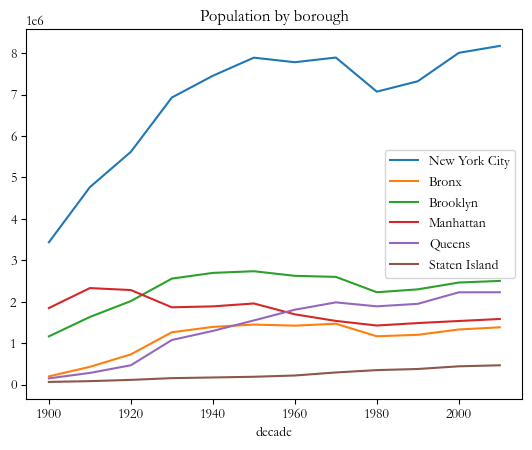

In [25]:
population_by_borough = pd.read_excel("https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/historical-population/nyc_total_pop_1900-2010.xlsx", skiprows = 3, index_col = 0)
population_by_borough = population_by_borough.dropna().reset_index(names = ["decade"])
# Plot 
population_by_borough.set_index("decade").plot(title = "Population by borough");

Foreign Born Population 

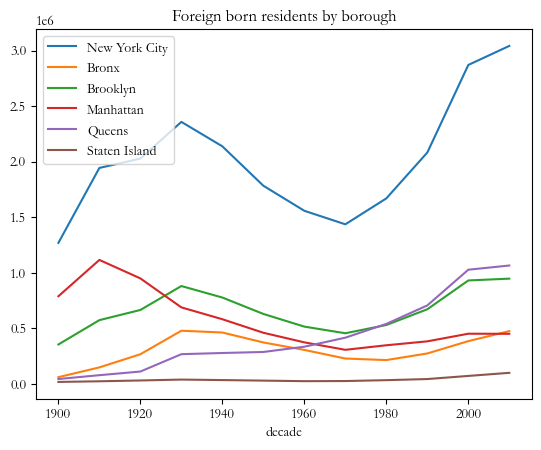

In [26]:
foreign_born_pop = pd.read_excel("https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/historical-population/nyc_fb_pop_1900-2010.xlsx", skiprows = 3, index_col = 0)
foreign_born_pop = foreign_born_pop.dropna().reset_index(names = ["decade"])
foreign_born_pop.decade = foreign_born_pop.decade.apply(lambda x: str(x).replace("*","")).astype(int)

foreign_born_pop.set_index("decade").plot(title = "Foreign born residents by borough");

In [27]:
share_of_foreign_born_by_decade = foreign_born_pop.drop("decade", axis = 1) / population_by_borough.drop("decade", axis = 1) * 100
share_of_foreign_born_by_decade["decade"] = foreign_born_pop.decade.copy()

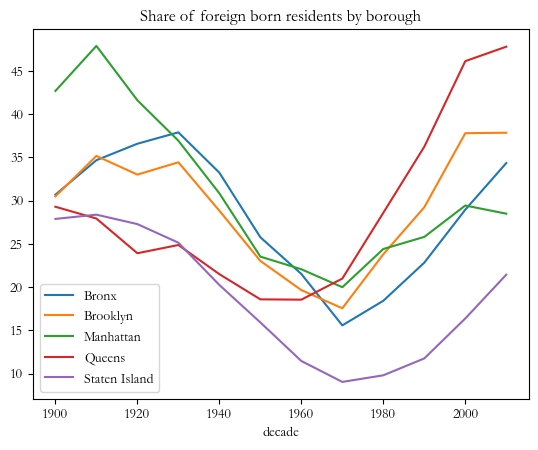

In [28]:
share_of_foreign_born_by_decade = foreign_born_pop.drop("decade", axis = 1) / population_by_borough.drop("decade", axis = 1) * 100
share_of_foreign_born_by_decade["decade"] = foreign_born_pop.decade.copy()

share_of_foreign_born_by_decade.drop("New York City",axis=1).set_index("decade").plot(title = "Share of foreign born residents by borough");

Kan lave kald direkte hertil: https://communityprofiles.planning.nyc.gov/?fbclid=IwAR1crIlc07XCsadzbgDzb2OWUodbM0SI3LMV7zICdrMmNJ-reBRG3zYc9p8

In [29]:
age_gender_dist = pd.read_csv("https://edm-publishing.nyc3.digitaloceanspaces.com/db-community-profiles/latest/output/cd_demo_age_gender.csv")
pov_race_dist = pd.read_csv("https://edm-publishing.nyc3.digitaloceanspaces.com/db-community-profiles/latest/output/cd_demo_race_economics.csv") 
build_and_land_use = pd.read_csv("https://edm-publishing.nyc3.digitaloceanspaces.com/db-community-profiles/latest/output/cd_built_environment.csv") 

In [30]:
# age_gender_dist["difference"] = age_gender_dist["pop_2010"]-age_gender_dist["pop_2000"]

# age_gender_dist.plot("cd_name", "pop_2000", kind="bar")
# age_gender_dist.plot("cd_name", "pop_2000", kind="bar")
# age_gender_dist.plot("cd_name", "difference", kind="bar")

### Districts code

101-112: Manhattan Community Districts
164: Central Park (JIA)
201-212: Bronx Community District
226: Van Cortlandt Park (JIA)
227: Bronx Park (JIA)
228: Pelham Bay Park (JIA)
301-318: Brooklyn Community Districts
355: Prospect Park (JIA)
356: Brooklyn Gateway National Recreation Area (JIA)
401-414: Queens Community Districts
480: LaGuardia Airport (JIA)
481: Flushing Meadow / Corona Park (JIA)
482: Forest Park (JIA)
483: JFK International Airport (JIA)
484: Queens Gateway National Recreation Area (JIA)
501-503: Staten Island Community Districts
595: Staten Island Gateway National Recreation Area (JIA)


GeoJSON fil til districter: https://data.cityofnewyork.us/City-Government/Community-Districts/yfnk-k7r4


# US Census

Målet er noget hen mod det her (selvom det helt sikkert at urealistisk at komme i nærheden af): https://www.nytimes.com/interactive/2015/07/08/us/census-race-map.html

Variable documentation for this particular data: https://www.census.gov/data/developers/data-sets/popest-popproj/popest/popest-vars.Vintage_2019.html#list-tab-794389051

See all available APIs at: https://www.census.gov/data/developers/data-sets.html

In [89]:
API_KEY = "ffe97aa3a40b95750950c76a41624538483d4731"

NY_STATE = ','.join(["36"])

COUNTIES = ','.join(["047", "061", "005", "081", "085"])


## ---- Map Labels ----- ## 
SEX_LABELS = {"0": "Both Sexes",
              "1": "Male",
              "2": "Female"}

HISP_LABELS = {"0": "Both Hispanic and Non-Hespanic Origins",
               "1": "Non-Hispanic",
               "2": "Hispanic"}

RACE_LABELS = {"0": "All races", # Har tilføjet race variablen
               "1": "White alone",
               "2": "Black alone",
               "3": "American Indian and Alaska Native alone",
               "5": "Asian alone",
               "6": "Two or more races",
               "7": "White alone or in combination",
               "8": "Black alone or in combination",
               "9": "American Indian and Alaska Native alone or in combination", 
               "10": "Asian alone or in combination",
               "11": "Native Hawaiian and Other Pacific Islander alone or in combination"}

COUNTY_TO_BOROUGH = {"081": "Queens",
                     "085": "Staten Island",
                     "047": "Brooklyn",
                     "005": "Bronx",
                     "061": "New York City"}

Kalder API'en

In [90]:
url = f"https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP,DATE_DESC&DATE_CODE=3,4,5,6,7,8,9,10,11,12&SEX=1,2&RACE=0,1,2,3,4,5,6,7,8,9,10,11&HISP=1,2&for=county:{COUNTIES}&in=state:{NY_STATE}&key={API_KEY}"
resp = requests.get(url).json()
df = pd.DataFrame(resp[1:], columns = resp[0])


# Clean data 
df["DATE"] = df.DATE_DESC.apply(lambda label: label.split(" ")[0])
df["YEAR"] = df.DATE.apply(lambda DATE: DATE.split("/")[-1])
df["SEX"] = df.SEX.map(SEX_LABELS)
df["RACE"] = df.RACE.map(RACE_LABELS)
df["HISP"] = df.HISP.map(HISP_LABELS)
df["BOROUGH"] = df.county.map(COUNTY_TO_BOROUGH)

# Drop excess columns 
df = df.drop(columns = ["DATE_CODE", "DATE_DESC", "state"])

## County Map 

Bruges ikke til noget, men skal lige tjekke om Boroughs og Counties can siges at være nogenlunde det samme i NYC...det tror jeg det kan.

In [33]:
county_data = gpd.read_file("Exam_datasets/georef-united-states-of-america-county.geojson")
county_data.ste_name = county_data.ste_name.apply(lambda x: x[0])
county_data.coty_name_long = county_data.coty_name_long.apply(lambda x: x[0])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "fiona\ogrext.pyx", line 136, in fiona.ogrext.gdal_open_vector
  File "fiona\_err.pyx", line 291, in fiona._err.exc_wrap_pointer
fiona._err.CPLE_OpenFailedError: Exam_datasets/georef-united-states-of-america-county.geojson: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\asger\AppData\Local\pypoetry\Cache\virtualenvs\social-visualization-CVtvBjxt-py3.11\Lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\asger\AppData\Local\Temp\ipykernel_3312\1531056555.py", line 1, in <module>
    county_data = gpd.read_file("Exam_datasets/georef-united-states-of-america-county.geojson")
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\asger\AppData\Local\pypoetry\Cache\virtualenvs\social-visualization-CV

In [34]:
NYC_counties = county_data[county_data.coty_name_long.isin(["Bronx County", "Kings County", "New York County", "Queens County", "Richmond County"])].query("ste_name == 'New York'")

fig, ax = plt.subplots()
NYC_counties.plot(color = "white", alpha = 0.3, edgecolor='black', ax = ax)
new_york_boroughs_map.plot(color = ["#FF0045", "#FFAA00", "#FF0000", "#00BCFF", "#B4FF00"], alpha = 0.3, ax = ax)
ax.set_title("Boroughs with county borders")
plt.show()

NameError: name 'county_data' is not defined

In [ ]:
## ----------- Left Overs ----------- ## 
# # Reverse geocode --> Join Point on Multipolygons 
# building_footprints["building_geometry"] = building_footprints.geometry.copy() # distinquish between geometry columns 
# buildings_in_bouroughs = gpd.sjoin(new_york_boroughs_map, building_footprints).reset_index(drop = True) # geo-merge
# buildings_in_bouroughs = buildings_in_bouroughs.rename(columns = {"name_left":"Bourough"}) # Rename